## Understanding NER
One of the well-known tasks in the category of token classification is NER – the
recognition of each token as an entity or not and identifying the type of each detected
entity. For example, a text can contain multiple entities at the same time – person names,
locations, organizations, and other types of entities. The following text is a clear example
of NER:
George Washington is one the presidents of the United States
of America.
George Washington is a person name while the United States of America is a location
name. A sequence tagging model is expected to tag each word in the form of tags, each
containing information about the tag. BIO's tags are the ones that are universally used for
standard NER tasks.
The following table is a list of tags and their descriptions:

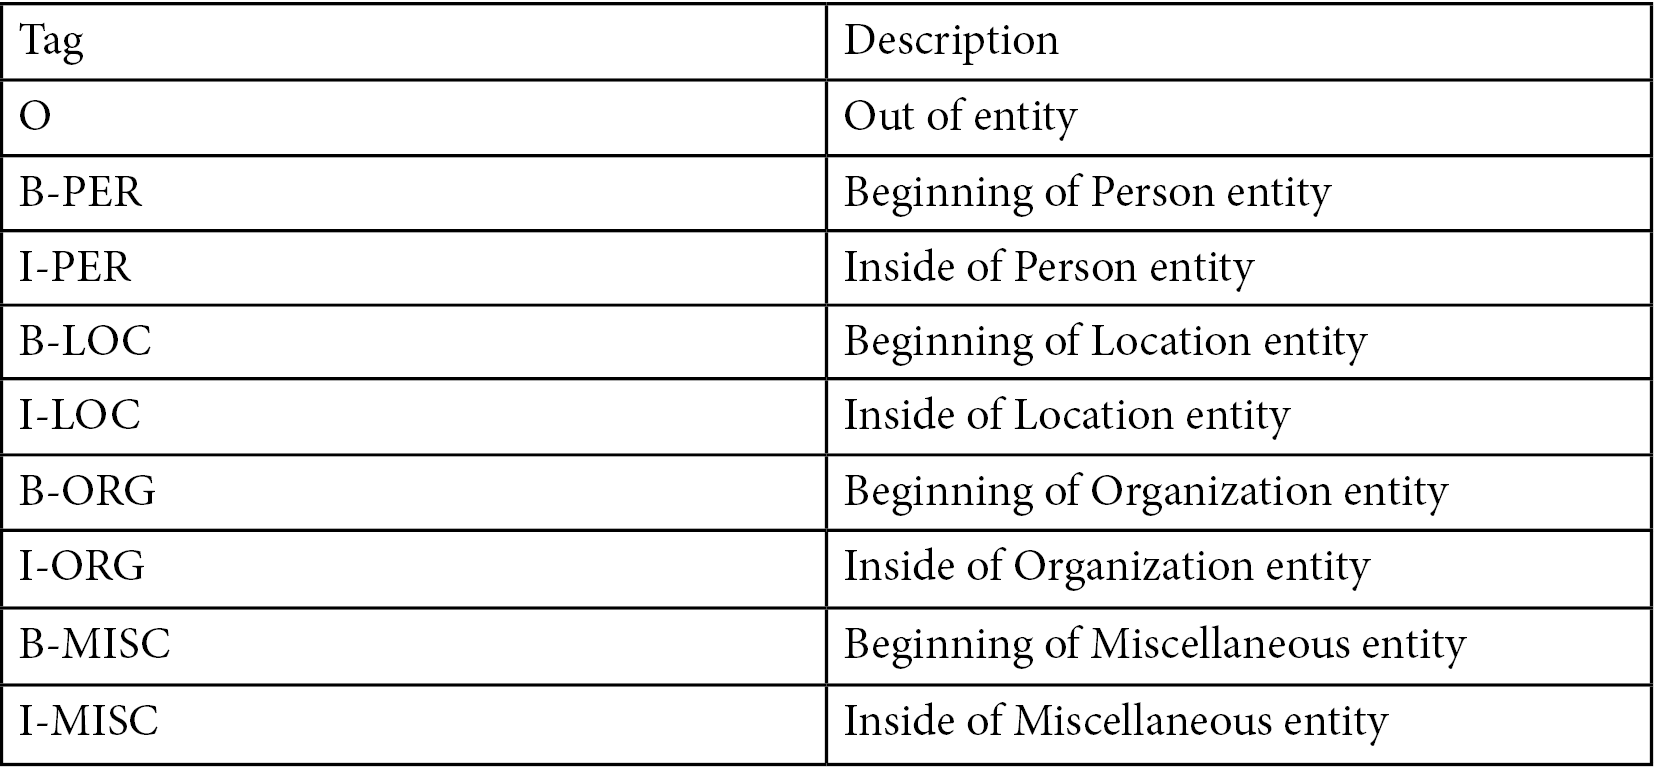

In [2]:
import datasets 
conll2003 = datasets.load_dataset("conll2003") 

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


In [3]:
conll2003["train"][0]

{'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'id': '0',
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.']}

In [4]:
conll2003["train"].features["ner_tags"]

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)

In [5]:
from transformers import BertTokenizerFast 
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased") 

In [6]:
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        previous_word_idx = None 
        label_ids = [] 
        for word_idx in word_ids: 
            if word_idx is None: 
                label_ids.append(-100) 
            elif word_idx != previous_word_idx: 
                 label_ids.append(label[word_idx]) 
            else: 
                 label_ids.append(label[word_idx] if label_all_tokens else -100) 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

In [7]:
q = tokenize_and_align_labels(conll2003['train'][4:5]) 
print(q) 

{'input_ids': [[101, 2762, 1005, 1055, 4387, 2000, 1996, 2647, 2586, 1005, 1055, 15651, 2837, 14121, 1062, 9328, 5804, 2056, 2006, 9317, 10390, 2323, 4965, 8351, 4168, 4017, 2013, 3032, 2060, 2084, 3725, 2127, 1996, 4045, 6040, 2001, 24509, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 5, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, -100]]}


In [8]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q["input_ids"][0]),q["labels"][0]): 
    print(f"{token:_<40} {label}") 

[CLS]___________________________________ -100
germany_________________________________ 5
'_______________________________________ 0
s_______________________________________ 0
representative__________________________ 0
to______________________________________ 0
the_____________________________________ 0
european________________________________ 3
union___________________________________ 4
'_______________________________________ 0
s_______________________________________ 0
veterinary______________________________ 0
committee_______________________________ 0
werner__________________________________ 1
z_______________________________________ 2
##wing__________________________________ 2
##mann__________________________________ 2
said____________________________________ 0
on______________________________________ 0
wednesday_______________________________ 0
consumers_______________________________ 0
should__________________________________ 0
buy_____________________________________ 0
sheep___

In [9]:
tokenized_datasets = conll2003.map(tokenize_and_align_labels, batched=True)

In [10]:
from transformers import AutoModelForTokenClassification 
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=9)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [11]:
from transformers import TrainingArguments, Trainer 
args = TrainingArguments( 
"test-ner",
evaluation_strategy = "epoch", 
learning_rate=2e-5, 
per_device_train_batch_size=16, 
per_device_eval_batch_size=16, 
num_train_epochs=3, 
weight_decay=0.01, 
) 

In [12]:
from transformers import DataCollatorForTokenClassification 
data_collator = DataCollatorForTokenClassification(tokenizer) 

In [14]:
metric = datasets.load_metric("seqeval") 

In [15]:
example = conll2003['train'][0]

In [16]:
label_list = conll2003["train"].features["ner_tags"].feature.names 

labels = [label_list[i] for i in example["ner_tags"]] 

metric.compute(predictions=[labels], references=[labels]) 

{'MISC': {'f1': 1.0, 'number': 2, 'precision': 1.0, 'recall': 1.0},
 'ORG': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

In [17]:
import numpy as np 
def compute_metrics(p): 
    predictions, labels = p 
    predictions = np.argmax(predictions, axis=2) 
    true_predictions = [ 
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(predictions, labels) 
    ] 
    true_labels = [ 
      [label_list[l] for (p, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(predictions, labels) 
   ] 
    results = metric.compute(predictions=true_predictions, references=true_labels) 
    return { 
   "precision": results["overall_precision"], 
   "recall": results["overall_recall"], 
   "f1": results["overall_f1"], 
  "accuracy": results["overall_accuracy"], 
  } 

In [18]:
trainer = Trainer( 
    model, 
    args, 
   train_dataset=tokenized_datasets["train"], 
   eval_dataset=tokenized_datasets["validation"], 
   data_collator=data_collator, 
   tokenizer=tokenizer, 
   compute_metrics=compute_metrics 
) 

In [19]:
trainer.train() 

The following columns in the training set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, ner_tags, id, pos_tags, tokens.
***** Running training *****
  Num examples = 14041
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2634


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.215900,0.064474,0.919602,0.931536,0.925531,0.983415
2,0.046700,0.057798,0.933015,0.939591,0.936291,0.985130
3,0.026200,0.056197,0.936439,0.944401,0.940403,0.986163


Saving model checkpoint to test-ner/checkpoint-500
Configuration saved in test-ner/checkpoint-500/config.json
Model weights saved in test-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-ner/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: chunk_tags, ner_tags, id, pos_tags, tokens.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 16
Saving model checkpoint to test-ner/checkpoint-1000
Configuration saved in test-ner/checkpoint-1000/config.json
Model weights saved in test-ner/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-ner/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-ner/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-ner/checkpoint-1500
Configuration saved in tes

TrainOutput(global_step=2634, training_loss=0.07719609297489523, metrics={'train_runtime': 499.622, 'train_samples_per_second': 84.31, 'train_steps_per_second': 5.272, 'total_flos': 1305498913871490.0, 'train_loss': 0.07719609297489523, 'epoch': 3.0})

In [20]:
model.save_pretrained("ner_model")

Configuration saved in ner_model/config.json
Model weights saved in ner_model/pytorch_model.bin


In [21]:
tokenizer.save_pretrained("tokenizer")

tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [22]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

In [23]:
import json

In [24]:
config = json.load(open("ner_model/config.json"))

In [25]:
config["id2label"] = id2label
config["label2id"] = label2id

In [26]:
json.dump(config, open("ner_model/config.json","w"))

In [27]:
mmodel = AutoModelForTokenClassification.from_pretrained("ner_model")

loading configuration file ner_model/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": "5",
    "B-MISC": "7",
    "B-ORG": "3",
    "B-PER": "1",
    "I-LOC": "6",
    "I-MISC": "8",
    "I-ORG": "4",
    "I-PER": "2",
    "O": "0"
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.2",
  "type_vocab_size":

In [28]:
from transformers import pipeline

In [29]:
nlp = pipeline("ner", model=mmodel, tokenizer=tokenizer)
example = "I live in Istanbul"

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-LOC', 'score': 0.9969446, 'index': 4, 'word': 'istanbul', 'start': 10, 'end': 18}]
